In [1]:
using GenericLinearAlgebra
using SymPy
using PyCall
using PyPlot
using LinearAlgebra

np = pyimport("numpy")

PyObject <module 'numpy' from '/Users/sofiapedraza/.julia/conda/3/x86_64/lib/python3.10/site-packages/numpy/__init__.py'>

In [2]:
function create_rho_list(levels = 3)
    rho_list = Sym[]
    for i in 1:levels
        for j in 1:levels
            push!(rho_list,Sym("rho_$(i)$(j)"))
        end
    end
    return rho_list #!Revisar lo de la asignación con las variables globales
end

create_rho_list (generic function with 2 methods)

In [3]:
function def_rho_matrix(levels)
    rho_matrix = Matrix{Sym}(undef,levels,levels)
    for i in 1:levels
        for j in 1:levels      
            rho_matrix[i, j] = symbols("rho_$(i)$(j)")
        end
    end #!Revisar lo de la asignación con las variables globales
    #println(rho_matrix)
    #println(rho_matrix[1,1])  #Julia comienza a contar en 1, no en 0 como python.
return rho_matrix
end

def_rho_matrix (generic function with 1 method)

In [4]:
function Hamiltonian(Omegas, Deltas)
    #Given lists of Rabi frequencies and detunings, construct interaction 
    """
    Hamiltonian (assuming RWA and dipole approximation) as per equation 14. 
    h_bar = 1 for simplicity.
    Both lists should be in ascending order (Omega_12, Omega_23 etc) """
    levels = length(Omegas)+1
    H = np.zeros((levels,levels),dtype="object")
    for i in 1:levels
        for j in 1:levels
            if i==j && i!=1
                H[i,j] = -2*(np.sum(Deltas[1:i-1]))
        
            elseif abs(i-j) == 1
                H[i,j] = Omegas[np.min([i,j])]
            end
        end
    end
    return np.matrix(H/2)
end

Hamiltonian (generic function with 1 method)

In [5]:
function L_decay(Gammas)
    """
    Given a list of linewidths for each atomic level, 
    construct atomic decay operator in matrix form for a ladder system.
    Assumes that there is no decay from the lowest level (Gamma_1 = 0).
    """
   
    levels = length(Gammas)+1
    rhos = def_rho_matrix(levels)
    Gammas_all = [0; Gammas] #Adds a zero because there is no decay from the lowest level
    decay_matrix = np.zeros((levels,levels), dtype = "object")
    
    for i in 1:levels
        for j in 1:levels
           
            if i != j
                decay_matrix[i,j] = -0.5*(
                    Gammas_all[i]+Gammas_all[j])*rhos[i,j]
                    
            elseif i != levels
                into = Gammas_all[i+1]*rhos[i+1, j+1]
                outof = Gammas_all[i]*rhos[i, j]
                decay_matrix[i,j] = into - outof
            
            else
                outof = Gammas_all[i]*rhos[i, j]
                decay_matrix[i,j] = - outof
                
            end
           
        end
    end
          
    return np.matrix(decay_matrix)
    
end

L_decay (generic function with 1 method)

In [6]:
function L_dephasing(gammas)
    """
    Given list of laser linewidths, create dephasing operator in matrix form. 

    Args:
        gammas (list): Linewidths of the field coupling each pair of states 
            in the ladder, from lowest to highest energy states 
            (gamma_{12}, ..., gamma{n-1,n} for n levels).

    Returns:
        numpy.matrix: Dephasing operator as a matrix populated by expressions 
            containing Sympy symbolic objects.
            Will be size nxn for an n-level system.
    """    
    levels = length(gammas)+1
    rhos = def_rho_matrix(levels)
    deph_matrix = np.zeros((levels, levels), dtype = "object")
    for i in 1:levels
        for j in 1:levels
            if i != j
                max=np.max([i,j])
                #if max == levels
                 #   max = levels-1
                #else max = np.max([i,j])
                #end
                deph_matrix[i,j] = -(np.sum(gammas[np.min(
                    [i,j]):max-1]))*rhos[i,j]
            end
        end
    end        
    return np.matrix(deph_matrix)
end


L_dephasing (generic function with 1 method)

In [7]:
function Master_eqn(H_tot, L)
    """
    Return an expression for the right hand side of the Master equation 
    (as in Eqn 18) for a given Hamiltonian and Lindblad term. 
    Assumes that the number of atomic levels is set by the shape of the 
    Hamiltonian matrix (nxn for n levels).

    Args:
        H_tot (matrix): The total Hamiltonian in the interaction picture.
        L (matrix): The Lindblad superoperator in matrix form. 

    Returns:
        numpy.matrix: Right hand side of the Master equation (eqn 18) 
        as a matrix containing expressions in terms of Sympy symbolic objects.
        Will be size nxn for an n-level system.
    """    
    levels = size(H_tot,1)
    dens_mat = def_rho_matrix(levels)
    return -1im*(H_tot*dens_mat - dens_mat*H_tot) + L
end


Master_eqn (generic function with 1 method)

In [8]:
function OBE_matrix(Master_matrix)
    """
    Take the right hand side of the Master equation (-i[H,\rho] + L) 
    expressed as an array of multiples of Sympy symbolic objects and output 
    an ndarray of coefficients M such that d rho_vect/dt = M*rho_vect 
    where rho_vect is the vector of density matrix elements.

    Args:
        Master_matrix (matrix): The right hand side of the Master equation 
            as a matrix of multiples of Sympy symbolic objects

    Returns:
        numpy.ndarray: An array of (complex) coefficients. 
            Will be size n^2 x n^2 for an n-level system.
    """    
    levels = size(Master_matrix,1)
    rho_vector = create_rho_list(levels)
    coeff_matrix = np.zeros((levels^2, levels^2), dtype = "complex")
    count = 1
    for i in 1:levels
        for j in 1:levels
            entry = Master_matrix[i,j]
            expanded = sympy.expand(entry)
            #use Sympy coeff to extract coefficient of each element in rho_vect
            for (n,r) in enumerate(rho_vector)
                coeff_matrix[count, n] = complex(expanded.coeff(sympy.sympify(r)))
            end 
            count += 1
        end
    end    
    return coeff_matrix
end

OBE_matrix (generic function with 1 method)

In [9]:
function SVD(coeff_matrix)
    """
    Perform singular value decomposition (SVD) on matrix of coefficients 
    using the numpy.linalg.svd function.
    SVD returns US(V)*^T where S is the diagonal matrix of singular values.
    The solution of the system of equations is then the column of V 
    corresponding to the zero singular value.
    If there is no zero singular value (within tolerance, allowing for 
    floating point precision) then return a zero array.

    Args:
        coeff_matrix (ndarray): array of complex coefficients M that satisfies 
            the expression d rho_vect/dt = M*rho_vect where rho_vect is the 
            vector of density matrix elements.

    Returns:
        ndarray: 1D array of complex floats corresponding to the steady-state 
            value of each element of the density matrix in the order given by 
            the rho_list function. Will be length n for an n-level system.
    """    
    levels = Int(np.sqrt(size(coeff_matrix,1)))
    u,sig,v = np.linalg.svd(coeff_matrix)
    abs_sig = np.abs(sig)
    minval = np.min(abs_sig)
    if minval>1e-12
        println("ERROR - Matrix is non-singular")
        return np.zeros((levels^2))
    end
    index = argmin(abs_sig)[1]
    rho = np.conjugate(v[index,:]) 
    #SVD returns the conjugate transpose of v
    pops = np.zeros((levels))
    for l in 0:levels-1
        pops[l+1] = (np.real(rho[l*(levels+1)+1]))
    end
    t = 1/(np.sum(pops)) #Normalise so the sum of the populations is one
    rho_norm = rho*t
    return rho_norm
end

SVD (generic function with 1 method)

In [10]:
function steady_state_soln(Omegas, Deltas, Gammas, gammas = [])
    """
    Given lists of parameters (all in order of lowers to highest energy level), 
    construct and solve for steady state of density matrix. 
    Returns ALL elements of density matrix in order of rho_list 
    (rho_11, rho_12, ... rho_i1, rho_i2, ..., rho_{n, n-1}, rho_nn).

    Args:
        Omegas (list of floats): Rabi frequencies of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Omega_{12}, ..., Omega{n-1,n} for n levels).
        Deltas (list of floats): Detuning of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Delta_{12}, ..., Delta{n-1,n} for n levels).
        Gammas (list of floats): Linewidth of the atomic states considered. 
            Assumes no decay from lowest energy atomic state (Gamma_1 = 0).
            Values should be given in order of lowest to highest energy level 
            (Gamma_2, Gamma_3, ... , Gamma_n for n levels). 
            n-1 values for n levels.
        gammas (list of floats, optional): Linewidths of the fields coupling 
            each pair of states in the ladder, from lowest to highest energy 
            (gamma_{12}, ..., gamma{n-1,n} for n levels). 
            Defaults to [] (meaning all gamma_ij = 0).

    Returns:
        ndarray: 1D array containing values for each element of the density 
            matrix in the steady state, in the order returned by the rho_list 
            function (rho_11, rho_12, ..., rho_{n, n-1}, rho_nn).
            Will be length n for an n-level system.
    """    
    L_atom = L_decay(Gammas)
    if length(gammas) != 0
        L_laser = L_dephasing(gammas)
        L_tot = L_atom + L_laser
    
    else
        L_tot = L_atom
    end
    H = Hamiltonian(Omegas, Deltas)
    Master = Master_eqn(H, L_tot)
    rho_coeffs = OBE_matrix(Master)
    soln = SVD(rho_coeffs)
    return soln
end

steady_state_soln (generic function with 2 methods)

In [11]:
function fast_3_level(Omegas, Deltas, Gammas, gammas = [])
    """
    Calculate the analytic solution of the steady-state probe coherence 
    (rho_{21}) in the weak probe limit for a 3-level ladder system.

    Args:
        Omegas (list of floats): Rabi frequencies of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Omega_{12}, ..., Omega{n-1,n} for n levels).
        Deltas (list of floats): Detuning of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Delta_{12}, ..., Delta{n-1,n} for n levels).
        Gammas (list of floats): Linewidth of the atomic states considered. 
            Assumes no decay from lowest energy atomic state (Gamma_1 = 0).
            Values should be given in order of lowest to highest energy level 
            (Gamma_2, Gamma_3, ... , Gamma_n for n levels). 
            n-1 values for n levels.
        gammas (list of floats, optional): Linewidths of the field coupling 
            each pair of states in the ladder, from lowest to highest energy 
            (gamma_{12}, ..., gamma{n-1,n} for n levels). 
            Defaults to [] (meaning all gamma_ij = 0).

    Returns:
        complex: steady-state value of the probe coherence (rho_{21})
        """  
    Delta_12, Delta_23 = Deltas[:]
    Omega_12, Omega_23 = Omegas[:]
    Gamma_2, Gamma_3 = Gammas[:]
    if length(gammas) != 0
        gamma_12, gamma_23 = gammas[:]
    
    else
        gamma_12, gamma_23 = 0, 0
    end
    expression = ((Omega_23^2)/4)/(1im*(Delta_12 + Delta_23) + (Gamma_3/2)
    + gamma_12 + gamma_23)
    bottom = (1im*Delta_12) + (Gamma_2/2) + gamma_12 + expression
    rho = (1im*Omega_12)/(2*bottom)
    
    return np.conjugate(rho)
end

fast_3_level (generic function with 2 methods)

In [12]:
function fast_4_level(Omegas, Deltas, Gammas, gammas = [])
    """
    Analytic solution of the steady-state probe coherence (rho_{21}) 
    in the weak probe limit for a 4-level ladder system.

    Args:
        Omegas (list of floats): Rabi frequencies of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Omega_{12}, ..., Omega{n-1,n} for n levels).
        Deltas (list of floats): Detuning of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Delta_{12}, ..., Delta{n-1,n} for n levels).
        Gammas (list of floats): Linewidth of the atomic states considered. 
            Assumes no decay from lowest energy atomic state (Gamma_1 = 0).
            Values should be given in order of lowest to highest energy level 
            (Gamma_2, Gamma_3, ... , Gamma_n for n levels). 
            n-1 values for n levels.
        gammas (list of floats, optional): Linewidths of the field coupling 
            each pair of states in the ladder, from lowest to highest energy  
            (gamma_{12}, ..., gamma{n-1,n} for n levels). 
            Defaults to [] (meaning all gamma_ij = 0).

    Returns:
        complex: steady-state value of the probe coherence (rho_{21})
    """    
    Omega_12, Omega_23, Omega_34 = Omegas[:]
    Delta_12, Delta_23, Delta_34 = Deltas[:]
    Gamma_2, Gamma_3, Gamma_4 = Gammas[:]
    if length(gammas) != 0
        gamma_12, gamma_23, gamma_34 = gammas[:]
    else
        gamma_12, gamma_23, gamma_34 = 0,0,0
    end
    bracket_1 = 1im*(Delta_12 + Delta_23 + Delta_34) - gamma_12 - gamma_23 - 
    gamma_34 - (Gamma_4/2)
    bracket_2 = 1im*(Delta_12 + Delta_23) - (Gamma_3/2) - gamma_12 - gamma_23 +
    (Omega_34^2)/(4*bracket_1)
    bracket_3 = 1im*Delta_12 - (Gamma_2/2) - gamma_12 + (
        Omega_23^2)/(4*bracket_2)
    return (1im*Omega_12)/(2*bracket_3)
end

fast_4_level (generic function with 2 methods)

In [13]:
function term_n(n, Deltas, Gammas, gammas = [])
    """
    Generate the nth term in the iterative expansion method for calculating 
    the probe coherence (rho_{21}) for an arbitrary number of levels in the 
    weak-probe limit.

    Args:
        n (int): Index (for n>0)
        Deltas (list of floats): Detuning of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Delta_{12}, ..., Delta{n-1,n} for n levels).
        Gammas (list of floats): Linewidth of the atomic states considered. 
            Assumes no decay from lowest energy atomic state (Gamma_1 = 0).
            Values should be given in order of lowest to highest energy level 
            (Gamma_2,Gamma_3, ... , Gamma_n for n levels). 
            n-1 values for n levels.
        gammas (list of floats, optional): Linewidths of the fields coupling 
            each pair of states in the ladder, from lowest to highest energy 
            (gamma_{12}, ..., gamma{n-1,n} for n levels).
            Defaults to [] (meaning all gamma_ij = 0).

    Returns:
        complex float: value of the probe coherence (\rho_{21}) 
            in the steady-state
    """
    if n > length(Deltas) || n > length(Gammas)
        throw(ArgumentError("n should be smaller or equal to the length of Deltas and Gammas"))
    end
    if length(gammas) == 0
        gammas = np.zeros((length(Deltas))) 
    end 
    # n>0
    return 1im*(np.sum(Deltas[1:n+1])) - (Gammas[n+1]/2) - np.sum(
        gammas[1:n+1])
end


term_n (generic function with 2 methods)

In [14]:
function time_op(operator, t)
    """Creates expresion for the time evolution operator. 

    Args:
        operator (matrix): Operator describing the time evolution of a system 
            in matrix form
        t (float): Time at which the expression is to be evaluated

    Returns:
        numpy.matrix: matrix form of the time evolution operator 
            exp^{operator*t}
    """    
    exponent = operator*t
    return exp(exponent) #linalg.expm does matrix exponentiation
end


time_op (generic function with 1 method)

In [15]:
function time_evolve(operator, t, psi_0)
    """
    Evaluate the state of a system at a time t, given an operator 
    describing its time evolution and the state of the system at t=0.

    Args:
        operator (matrix): matrix representation of operator describing 
            time evolution of the system.
        t (float): Time at which the state of the system is to be evaluated.
        psi_0 (1D array): Vector describing the initial state of the system 
            (at t=0).

    Returns:
        1D array: the state of the system at time t
    """    
    return np.matmul(time_op(operator, t), psi_0)
end

time_evolve (generic function with 1 method)

In [16]:
function time_dep_matrix(Omegas, Deltas, Gammas, gammas = [])
    """
    Given lists of parameters (all in order of lowers to highest energy level), 
    construct matrix of coefficients for time evolution of 
    the density matrix vector.

    Args:
        Omegas (list of floats): Rabi frequencies of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Omega_{12}, ..., Omega{n-1,n} for n levels).
        Deltas (list of floats): Detuning of fields coupling each pair 
            of states in the ladder, from lowest to highest energy states 
            (Delta_{12}, ..., Delta{n-1,n} for n levels).
        Gammas (list of floats): Linewidth of the atomic states considered. 
            Assumes no decay from lowest energy atomic state (Gamma_1 = 0).
            Values should be given in order of lowest to highest energy level 
            (Gamma_2, Gamma_3, ... , Gamma_n for n levels). 
            n-1 values for n levels.
        gammas (list of floats, optional): Linewidths of the fields coupling 
            each pair of states in the ladder, from lowest to highest energy 
            (gamma_{12}, ..., gamma{n-1,n} for n levels).
            Defaults to [] (meaning all gamma_ij = 0).  
    Returns:
        ndarray: n^2 x n^2 array (for an n-level system) of coefficients M 
            which satisfies the equation drho_{vect}/dt = Mrho_{vect} 
            where rho_{vect} is the vector representation of the 
            density matrix.
    """    
    # first create decay/dephasing operators
    L_atom = L_decay(Gammas)
    if length(gammas) != 0
        L_laser = L_dephasing(gammas)
        L_tot = L_atom + L_laser
    else
        L_tot = L_atom
    end
    H = Hamiltonian(Omegas, Deltas) #create the total Hamiltonian
    Master = Master_eqn(H, L_tot) 
    rho_coeffs = OBE_matrix(Master) #create matrix of coefficients
    return rho_coeffs
end

time_dep_matrix (generic function with 2 methods)

In [17]:
Deltas = [1]
Omegas = [2]
Gammas = [5]
gammas = [0.1]
Ldecay = L_decay(Gammas)
Ldeph = L_dephasing(gammas)
L = Ldecay+Ldeph
H = Hamiltonian(Omegas, Deltas)
master=Master_eqn(H,L)
coeff_mat=OBE_matrix(master)
svd=SVD(coeff_mat)
#x = time_dep_matrix(Omegas, Deltas, Gammas, gammas)


ComplexF64[0.0 + 0.0im 0.0 + 1.0im 0.0 - 1.0im 5.0 + 0.0im; 0.0 + 1.0im -2.6 - 1.0im 0.0 + 0.0im 0.0 - 1.0im; 0.0 - 1.0im 0.0 + 0.0im -2.6 + 1.0im 0.0 + 1.0im; 0.0 + 0.0im 0.0 - 1.0im 0.0 + 1.0im -5.0 + 0.0im]


/Users/sofiapedraza/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sofiapedraza/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


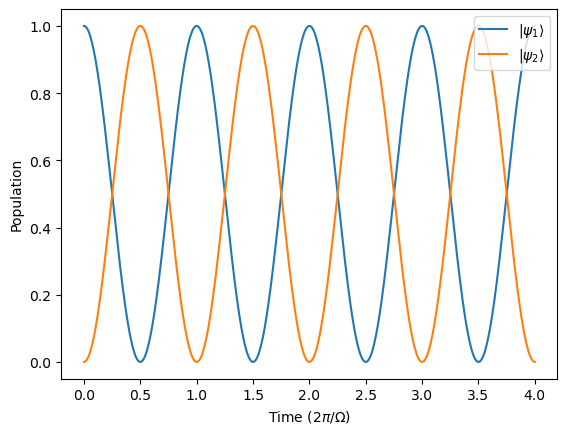

In [20]:
# Define time array
times = range(0, stop=8 * π, length=500)

# Define parameters
Omegas = [1.0]
Deltas = [0.0]

# Create Hamiltonian
H = Hamiltonian(Omegas, Deltas)

# Define initial state vector at t=0
psi_0 = [1.0, 0.0]

# Initialize array to store populations
pops = zeros(Complex{Float64}, length(times), 2)
#pops = zeros(Float64, length(times), 2)

for (i, t) in enumerate(times)
    sol = time_evolve(-1.0im * H, t, psi_0) # Perform time evolution
    c_1, c_2 = sol[1], sol[2]  # Extract coefficients
    # Calculate populations
    factor = abs2(c_1) + abs2(c_2) 
    popn = [abs2(c_1), abs2(c_2)]
    pops[i, :] = popn / factor
end

figure()
plot(times / (2 * π), pops[:, 1], label = L"|\psi_1\rangle")
plot(times / (2 * π), pops[:, 2], label = L"|\psi_2\rangle")
legend(loc="upper right")
xlabel("Time (\$2\\pi/\\Omega\$)")
ylabel("Population")
show()

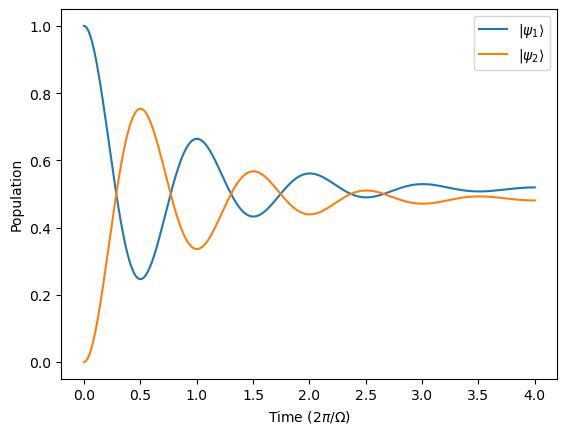

In [21]:
# Define time array
times = range(0, stop=8 * π, length=500)

# Define parameters
Omegas = [1.0]
Deltas = [0.0]
Gammas = [Omegas[1] / 4.0]
M = time_dep_matrix(Omegas, Deltas, Gammas)

# Define initial density matrix
rho_0 = [1.0, 1.0, 1.0, 0.0]
rho_t = zeros(Float64, length(times), 4)
pops = zeros(Float64, length(times), 2)

for (i, t) in enumerate(times)
    sol = time_evolve(M, t, rho_0) # Perform time evolution
    rho_11, rho_22 = real(sol[1]), real(sol[4]) # Extract populations
    # Calculate factor and populations
    factor = rho_11 + rho_22
    popn = [rho_11, rho_22]
    pops[i, :] = popn / factor
end

figure()
plot(times / (2 * π), pops[:, 1], label = L"|\psi_1\rangle")
plot(times / (2 * π), pops[:, 2], label = L"|\psi_2\rangle")
legend(loc="upper right")
xlabel("Time (\$2\\pi/\\Omega\$)")
ylabel("Population")
show()

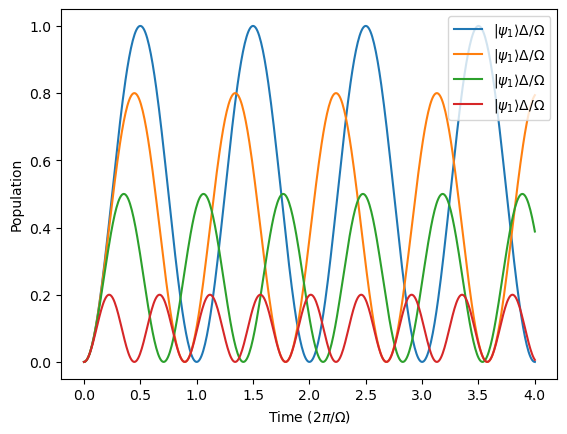

In [25]:
# Define time array
times = range(0, stop=8 * π, length=500)

# Define parameters

Omega1 = [1.0]
Delta1 = [0.0]
Delta2 = [0.5]
Delta3 = [1.0]
Delta4 = [2.0]
Deltas = [Delta1, Delta2, Delta3, Delta4]
# Define initial state vector at t=0
psi_0 = [1.0, 0.0]

# Create Hamiltonian
#Make a plot of the populations of the first state for each of the different detunings

#Make a hamiltonian for each of the different detunings
figure()
for i in 1:length(Deltas)
    H = Hamiltonian(Omega1, Deltas[i[1]])
    # Initialize array to store populations for each detuning
    pops = zeros(Complex{Float64}, length(times), 2)

    #Evolve the system for each detuning
    for (j, t) in enumerate(times)
        sol = time_evolve(-1.0im * H, t, psi_0) # Perform time evolution
        c_1, c_2 = sol[1], sol[2]  # Extract coefficients
        # Calculate populations
        factor = abs2(c_1) + abs2(c_2) 
        popn = [abs2(c_1), abs2(c_2)]
        pops[j, :] = popn / factor
    end
    #pops = zeros(Float64, length(times), 2)
    plot(times / (2 * π), pops[:, 2], label = L"|\psi_1\rangle \Delta/\Omega ")
    
    
end

legend(loc="upper right")
    xlabel("Time (\$2\\pi/\\Omega\$)")
    ylabel("Population")


show()